# Multi-armed Bandits

This chapter presents several simple methods that perform the exploitation-exploration balancing act for the multi-armed or *k*-armed bandit problem.

The $k$-armed bandit problem is defined as follows:

> You are faced repeatedly with a choice among $k$ different options, or actions. After each choice you receive a numerical reward chosen from a stationary probability distribution that depends on the action you selected. Your objective is to maximize the expected total reward over some time period, for example, over 1000 action selections or _time steps_.

It is a _nonassociative task_.

## Definitions

**Nonassociative Tasks**: One situation. There is _no need to associate different actions with different situations_. In these tasks, the learner either tries to find a single best action when the task is stationary, or tries to track the best action as it changes over time when the task is nonstationary.

**Associative Tasks**: More than one situation and the goal is to learn a policy (mapping from situations to the actions that are best in those situations).

**Greedy Action**: The action $a$ that has highest estimated value $Q_t(a)$. Selecting the greedy action exploits the agents current knowledge of the values of each action.

**Action-value Methods**: Methods that estimate the values of actions and for using the estimates to make action selection decisions.

**$\epsilon$-greedy Methods**: Methods that select the greedy action most of the time but ocassionally, with small probability $\epsilon$, select randomly from among all actions with equal probability.

**Update Rule**: A general equation for incrementally updating an estimate of a variable when given possibly stochastic samples of it: $\text{NewEstimate} \leftarrow \text{OldEstimate} + \text{StepSize} \left[ \text{Target} - \text{OldEstimate} \right]$.

## Notation

$t$: The time step.

$A_t$: The action selected on time step $t$.

$R_t$: The reward given action $A_t$ was selected.

$q_*(a) = \mathbb{E}[R_t \mid A_t = a]$: The value (expected reward) of an arbitrary action $a$.

$Q_t(a)$: The estimated value of action $a$ at time step $t$.

$\alpha_t(a)$: Step size in the update rule.

## Action-value Methods

### Sample-average Methods

The true value of an action is the mean reward when that action is selected. A natural estimate for this is to average the rewards that have actually been received:

\begin{align*}
    Q_t(a)
        &\dot{=} \frac{\text{sum of rewards when $a$ taken prior to $t$}}
                      {\text{number of times $a$ taken prior to $t$}} \\
        &= \frac{\sum_{i = 1}^{t - 1} R_i \cdot \mathbb{1}_{A_i = 1}}
                {\sum_{i = 1}^{t - 1} \mathbb{1}_{A_i = 1}}
\end{align*}

If the denominator is 0 then $Q_t(a)$ is defined as a default value such as 0.

As the denominator goes to infinity, by the law of large numbers, $Q_t(a)$ converges to $q_*(a)$.

The simplest action selection rule spends no time exploring and simple selects the greedy action:

$$
A_t \dot{=} \text{argmax}_a Q_t(a)
$$

A simple alternative is to behave greedily most of the time but with occasionally, with small proability $\epsilon$, select randomly from among all actions with equal probability.

In the limit as the number of steps increases every action will be sampled an infinite number of times thus ensuring that all $Q_t(a)$ converge to $q_*(a)$. This asymptotic guarantee says little about the practical effectiveness of the methods.

#### Linear Compute and Memory

The $\epsilon$-greedy agent implementation could store the list of rewards received so far for each action. It could then use this information to calculate the expected reward:

\begin{equation}
    Q_n \dot{=} \frac{R_1 + R_2 + \cdots + R_{n - 1}}{n - 1}
\end{equation}

This leads to a linear increase in compute and memory requirements which is not good!

#### Constant Compute and Memory

An optimization of this is for the agent to instead store for each action the sum of the rewards ($R_1 + R_2 + \cdots + R_{n - 1}$) and taken count ($n - 1$). 

Each step only requires the agent to compute the expected rewards for each action by dividing the reward sums by the taken counts, compute the maximum expected reward if greedy, and add the reward and increment the taken count of the chosen action.

This works and has a computational and memory complexity of $O(1)$.

Another constant compute and memory implementation, known as an **incremental implementation**, introduces the canonical _update rule_. The rule is derived as follows:

\begin{align*}
    Q_{n + 1} &= \frac{1}{n} \sum_{i=1}^{n}{R_i} \\
              &= \frac{1}{n} \left( R_n + \sum_{i=1}^{n - 1}{R_i} \right) \\
              &= \frac{1}{n} \left( R_n + (n - 1)\frac{1}{n - 1} \sum_{i=1}^{n - 1}{R_i} \right) \\
              &= \frac{1}{n} \left( R_n + (n - 1) Q_n \right) \\
              &= \frac{1}{n} \left( R_n + nQ_n - Q_n \right) \\
              &= Q_n + \frac{1}{n} \left[ R_n - Q_n \right]
\end{align*}

The new expected value is equal to the old expected value plus a constant factor. If the reward is greater than the current expected value then the new expected value increases. If the reward is less than the current expected value then the new expected value decreases. The amount of increase and decrease decays as the number of times the action is taken increases. 

#### Update Rule

The general form of the equation derived above is:

\begin{equation}
    \text{NewEstimate} \leftarrow 
        \text{OldEstimate} + \text{StepSize} \left[ \text{Target} - \text{OldEstimate} \right]
\end{equation}

This is known as the **update rule** where $\left[ \text{Target} - \text{OldEstimate} \right]$ is called the **error** in the estimate.

In general the $\text{StepSize}$ is a function of both the action and time step and is denoted $\alpha_t(a)$. 

#### Pseudocode

Pseudocode for the incrementally computed sample average and $\epsilon$-greedy action selection methods is:

```python
def argmax(values: Sequence):
    return max(zip(values, range(len(values))), key=lambda x: x[0])[1]

def simple_bandit(bandit: Callable[int, action], n_actions: int, epsilon: float):
    q = [0 for _ in range(n_actions)]
    n = [0 for _ in range(n_actions)]
    
    while True:
        if random.random() < epsilon:
            action = random.randint(0, n_actions - 1)
        else:
            action = argmax(q)
            
        reward = bandit(action)
        n[action] += 1
        q[action] += (1.0 / n[action]) * (reward - q[action])
```

#### Practical Implementation

The code below implements a 10-_armed testbed_ and incremental update $\epsilon$-greedy and greedy bandits (agents) to evaluate the practical effectiveness of the methods.

It runs on either the CPU or GPU and utilises PyTorch's jit to improve performance (i.e. simulated time steps per second).

In [33]:
from itertools import islice

import matplotlib.pyplot as plt
import torch

# make matplotlib pretty and increase plot size
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = 12, 6

Begin by implementing an iterator that can generate data for `runs` different bandit problems at once and use this to replicate Figure 2.1 in the book.

In [34]:
class BanditProblem(torch.utils.data.IterableDataset):
    """A Bandit Problem iterable.
    
    Returns an iterator that returns torch Tensors of size
    `(runs, arms)` where the values are drawn from a normal
    distribution with mean `action_vals` and standard
    deviation 1.
    
    Args:
        arms: The number of arms (actions).
        runs: The number of different bandit problems (runs)
            to generate at once.
        device: Device on which to generate data.
        
    Attributes:
        action_vals: A torch Tensor of size (runs, arms) where
            the values are drawn from a normal distribution
            with mean 0, standard deviation 1.
        optimal: A torch Tensor of size (runs,) where each value
            is an integer denoting the greatest value in each
            row of `action_vals`.
    """
    def __init__(self, arms=10, runs=1, device=torch.device("cpu")):
        super().__init__()
        self.runs = runs
        self.action_vals = torch.empty(runs, arms, device=device).normal_()
        # indices of optimal action (max expected value)
        self.optimal = torch.argmax(self.action_vals, dim=1)
        self.device = device
        
    def __iter__(self):
        return self
        
    def __next__(self):
        return torch.normal(self.action_vals, torch.ones_like(self.action_vals))

In [35]:
bp = BanditProblem()

In [36]:
# violin plot requires raw data 
time_steps = 1000
vals = torch.stack(list(islice(bp, time_steps)))   # shape: [time_steps, runs=1, arms=10]
vals = vals.squeeze(dim=1)                         # squeeze runs dimension
vals = vals.T                                      # shape: [arms, time_steps]

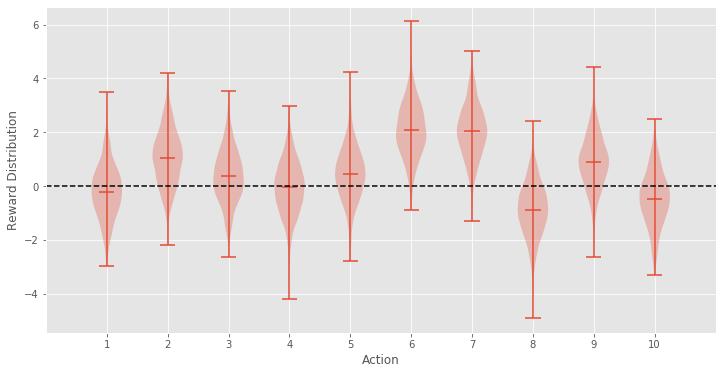

In [37]:
plt.violinplot(dataset=vals, showmeans=True)

plt.hlines(y=0, xmin=0, xmax=11, linestyles='dashed')

plt.xlabel("Action")
plt.ylabel("Reward Distribution")

plt.xlim(0, 11)

plt.xticks(ticks=list(range(1, 11)))

plt.show()

Now implement an $\epsilon$-greedy bandit/agent and use it to replicate Figure 2.2 in the book that plots on separate axes the average reward and optimal action percentage for 1000 time steps, averaged over 2000 different bandit problems (runs), for $\epsilon=0$ (greedy), $\epsilon=0.1$ and $\epsilon=0.01$.

Note that like the `BanditProblem` implementation above the `EpsilonAgent` can simulate multiple runs at once to improve performance.

In [86]:
class EpsilonAgent(torch.nn.Module):
    """An epsilon-greedy bandit.
    
    Args:
        arms: The number of arms (actions).
        runs: The number of different agents to simulate.
        epsilon: Float between [0, 1] denoting the percentage
            of time the agent should sample actions randomly
            (explore).
    """
    def __init__(self, arms=10, runs=1, epsilon=0.0):
        super().__init__()
        self.epsilon = epsilon
        self.arms = arms
        self.runs = runs
        # register as buffers to enable PyTorch to move values to devices
        self.register_buffer("value_estimates", torch.zeros(runs, arms))
        self.register_buffer("action_counts", torch.zeros(runs, arms, dtype=torch.int32))
        self.register_buffer("time_step", torch.tensor(0))
        
    def forward(self, x):
        # generate explore and exploit actions for all runs
        explore = torch.randint(
            high=self.arms, size=(self.runs,), dtype=torch.long, device=x.device
        )
        exploit = torch.argmax(self.value_estimates, dim=1)

        # for each action, decide whether to explore or exploit
        if self.time_step == 0:
            # all actions randomly sample on first step
            choice = torch.zeros(self.runs, dtype=torch.bool, device=x.device)
        else:
            # each action randomly samples epsilon percent of time
            choice = torch.rand(self.runs, device=x.device) < self.epsilon
        
        # select explore or exploit actions given choice
        actions = torch.where(choice, explore, exploit)
        
        # update action value estimates and taken counts for all runs
        actions_idx = actions.view(-1, 1)   # gather/scatter req n_dims to be equal
        counts = torch.gather(
            self.action_counts, dim=1, index=actions_idx
        )
        counts += 1
        
        value_estimates = torch.gather(
            self.value_estimates, dim=1, index=actions_idx
        )
        rewards = torch.gather(
            x, dim=1, index=actions_idx
        )
        value_estimates += (1.0 / counts.float()) * (rewards - value_estimates)
        
        self.action_counts.scatter_(
            src=counts, dim=1, index=actions_idx
        )
        self.value_estimates.scatter_(
            src=value_estimates, dim=1, index=actions_idx
        )
        self.time_step += 1
        
        return actions

In [87]:
def simulate(agent, runs, time_steps, log_every=1, device=torch.device("cpu"), jit=False):
    """Returns a tuple of tensors containing the average reward and optimal action percentages.
    
    Args:
        agent: EpsilonAgent.
        runs: Number of runs/problems to simulate.
        time_steps: Number of time steps to simulate.
        log_every: Number of steps between logs of reward and optimal choice percents.
        device: Device to use.
        jit: If True, apply `torch.jit.script` to agent.
        
    Returns:
        Tuple of (average_reward, opt_freq).
        
        `average_reward` is a torch Tensor of size (time_steps + 1,) where
        the ith value is the ith reward averaged over all `runs`.
        
        `opt_freq` is a torch Tensor of size (time_steps + 1,) where the ith
        value gives the percentage of chosen actions that were optimal
        at step i averaged over all `runs`.
    """
    # move agent to device and maybe script
    agent.to(device)
    if jit:
        agent = torch.jit.script(agent)
        
    # initialize data generator
    bp = BanditProblem(runs=runs, device=device)

    # initialize tensors to hold logged values
    agent_rewards = torch.empty(time_steps // log_every, bp.runs, device=device)
    agent_actions = torch.empty(time_steps // log_every, bp.runs, dtype=torch.long, device=device)
    optimal = torch.empty(time_steps // log_every, bp.runs, dtype=torch.bool, device=device)

    # iterate over all time_steps
    for t, rewards in enumerate(bp):
        if t == time_steps:
            break

        actions = agent(rewards)
        
        if t % log_every == 0:   
            opt = actions == bp.optimal
            rewards = torch.gather(
                rewards, dim=1, index=actions.view(bp.runs, 1)
            )[:, 0]
            agent_rewards[t // log_every] = rewards
            agent_actions[t // log_every] = actions
            optimal[t // log_every] = opt
    
    average_reward = agent_rewards.mean(dim=1)
    opt_freq = optimal.float().mean(dim=1)
    
    return average_reward, opt_freq

In [90]:
arms = 10
runs = 2000
time_steps = 100000
log_every = 100

results = {}
for eps in [0.0, 0.01, 0.1]:
    print(eps)
    eps_results = simulate(
        agent=EpsilonAgent(arms, runs, eps), 
        runs=runs, 
        time_steps=time_steps,
        log_every=log_every,
        device=torch.device("cuda:0"),
        jit=True
    )
    results[eps] = tuple(r.cpu() for r in eps_results)

0.0
0.01
0.1


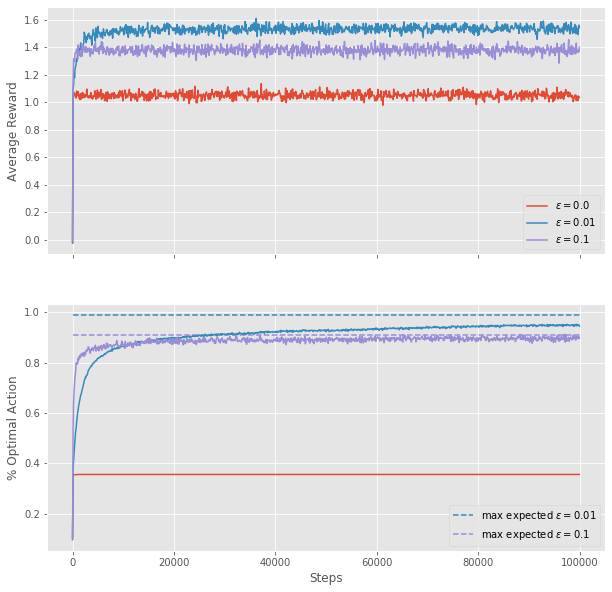

In [92]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 10))

for eps, (avg_reward, opt_freq) in results.items():
    x = range(0, time_steps, log_every)
    legend = ax1.plot(x, avg_reward, label=f"$\epsilon={eps}$")
    ax2.plot(x, opt_freq)
    
    # draw line showing roofline optimal action percentage
    # for eps != 0
    if eps == 0:
        continue
    ax2.hlines(
        y=(1.0 - eps) + eps**2, 
        xmin=0, 
        xmax=time_steps,
        linestyles="dashed",
        color=legend[0].get_color(),
        label=f"max expected $\epsilon={eps}$"
    )
    
ax1.set_ylabel("Average Reward")
ax2.set_xlabel("Steps")
ax2.set_ylabel("% Optimal Action")

ax1.legend()
ax2.legend(loc="lower right")
plt.show()